In [3]:
import pandas as pd
import numpy as np
import requests
import sqlite3
import yfinance as yf

In [2]:
# Data: sentiment, fin_ratios, stock_price_data

In [5]:
df_stock_price = pd.read_csv('stock_data.zip',compression='zip',header=[0,1],index_col=0, parse_dates=True)

In [4]:
df['AADI']

NameError: name 'df' is not defined

In [6]:
def find_closest_index(date, available_dates):
    closest_index = min(available_dates, key=lambda x: abs(pd.Timestamp(x) - pd.Timestamp(date)))
    return available_dates.index(closest_index)

In [47]:
def find_features(df, date, ticker):
    df = df[ticker]
    available_dates = list(df.index)
    idx_event = find_closest_index(date, available_dates)
    
    # 5,10,30 day average
    avg_5 = np.array(df.iloc[idx_event-5:idx_event, df.columns.get_loc('close')]).mean()
    avg_10 = np.array(df.iloc[idx_event-10:idx_event, df.columns.get_loc('close')]).mean()
    avg_30 = np.array(df.iloc[idx_event-30:idx_event, df.columns.get_loc('close')]).mean()
    
    # 5,10,30 day standard dev 
    std_5 = np.array(df.iloc[idx_event-5:idx_event, df.columns.get_loc('close')]).std()
    std_10 = np.array(df.iloc[idx_event-10:idx_event, df.columns.get_loc('close')]).std()
    std_30 = np.array(df.iloc[idx_event-30:idx_event, df.columns.get_loc('close')]).std()
    
    # 5 day average and standard dev of returns
    avg_5_day_ret = np.array(df.iloc[idx_event-5:idx_event, df.columns.get_loc('close')].pct_change().dropna()).mean()
    std_5_day_ret = np.array(df.iloc[idx_event-5:idx_event, df.columns.get_loc('close')].pct_change().dropna()).std()

    # Average True Range (ATR)
    
    ohlc_subset_10 = df.iloc[idx_event-10:idx_event, :].copy(deep=True)

    ohlc_subset_10['HL'] = ohlc_subset_10.iloc[:, ohlc_subset_10.columns.get_loc('high')] - ohlc_subset_10.iloc[:, ohlc_subset_10.columns.get_loc('low')]
    ohlc_subset_10['HC'] = ohlc_subset_10.iloc[:, ohlc_subset_10.columns.get_loc('high')] - ohlc_subset_10.iloc[:, ohlc_subset_10.columns.get_loc('close')].shift(1)
    ohlc_subset_10['LC'] = ohlc_subset_10.iloc[:, ohlc_subset_10.columns.get_loc('low')] - ohlc_subset_10.iloc[:, ohlc_subset_10.columns.get_loc('close')].shift(1)
    ohlc_subset_10['TR'] = ohlc_subset_10[['HL', 'HC', 'LC']].max(axis=1)
    atr_10 = ohlc_subset_10['TR'].mean()

    volume_std_10 = np.array(df.iloc[idx_event-10:idx_event, df.columns.get_loc('volume')]).std()
    trans_std_10 = np.array(df.iloc[idx_event-10:idx_event, df.columns.get_loc('transactions')]).std()

    prev_vol = df.iloc[idx_event-1, df.columns.get_loc('volume')]
    prev_trans = df.iloc[idx_event-1, df.columns.get_loc('transactions')]


    
    # Market cap from Polygon 
    api_key = '0cWQq_K4hIpXGKtVRB80dNvtiSm4OiNJ'
    url = f'https://api.polygon.io/v3/reference/tickers/{ticker}?date={date[:10]}&apiKey=0cWQq_K4hIpXGKtVRB80dNvtiSm4OiNJ'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        results = data.get('results', [])
        if results:
            mkt_cap = results['market_cap']
    else:
        mkt_cap = np.nan
    
    return avg_5-avg_10, avg_5-avg_30, std_5-std_10, std_5-std_30, mkt_cap, avg_5_day_ret, std_5_day_ret, atr_10, volume_std_10, trans_std_10, prev_vol, prev_trans

In [43]:
a,b,c,d,e,f,g,h,i,j,k,l = find_features(df_stock_price, '2022-10-27', 'SPPI') 

In [31]:
test = df_stock_price['SPPI']

5670.0

# Read data from catalysts

In [48]:
# Create a SQLite database and connect to it
conn = sqlite3.connect('final_data.db')

# Query the SQL table (selecting all data)
query = 'SELECT * FROM ALL_FEATURES'
df = pd.read_sql(query, conn)


conn.close()


In [ ]:
tickers = list(df['ticker'])
dates = list(df['date'])
a_list, b_list, c_list, d_list, e_list, f_list, g_list, h_list, i_list, j_list, k_list, l_list = [],[],[],[],[],[],[],[],[],[],[],[]
count = 1
for ticker, date in zip(tickers,dates):
    if ticker not in ['RLFTF','RHHBY','PHRRF','ZLDPF','EVFM','IPSEY','NWBO','IGXT','ALPMY','QSAM',
                     'APLIF']:
        print(f'doing ticker {ticker} number {count}...')
        a,b,c,d,e,f,g,h,i,j,k,l = find_features(df_stock_price, date, ticker)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        d_list.append(d)
        e_list.append(e)
        f_list.append(f)
        g_list.append(g)
        h_list.append(h)
        i_list.append(i)
        j_list.append(j)
        k_list.append(k)
        l_list.append(l)
    if ticker in ['RLFTF','RHHBY','PHRRF','ZLDPF','EVFM','IPSEY','NWBO','IGXT','ALPMY','QSAM',
                 'APLIF']:
        a_list.append(np.nan)
        b_list.append(np.nan)
        c_list.append(np.nan)
        d_list.append(np.nan)
        e_list.append(np.nan)
        f_list.append(np.nan)
        g_list.append(np.nan)
        h_list.append(np.nan)
        i_list.append(np.nan)
        j_list.append(np.nan)
        k_list.append(np.nan)
        l_list.append(np.nan)
    count += 1
    
df['avg_5_10'] = a_list
df['avg_5_30'] = b_list
df['std_5_10'] = c_list
df['std_5_30'] = d_list
df['mkt_cap'] = e_list
df['avg_5_day_ret'] = f_list
df['std_5_day_ret'] = g_list
df['atr_10'] = h_list
df['volume_std_10'] = i_list
df['trans_std_10'] = j_list
df['prev_vol'] = k_list
df['prev_trans'] = l_list


In [50]:
# Dropping the 20_day_pct_ret
df = df.drop(['20_day_pct_ret'], axis=1)

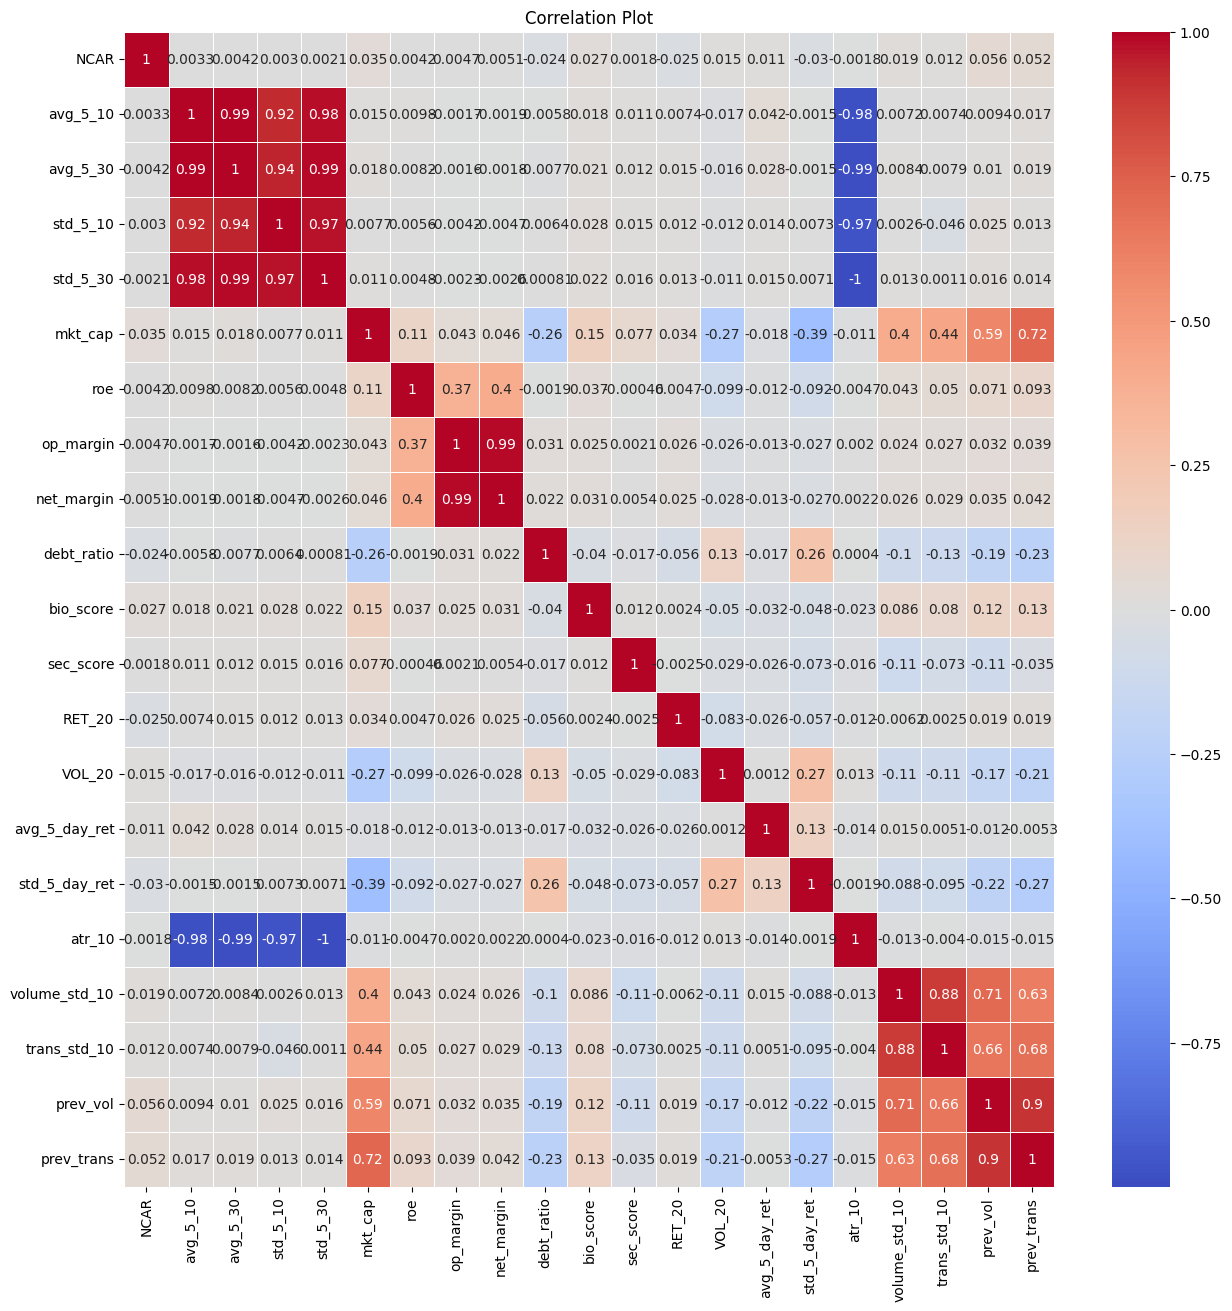

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
# Calculate the correlation matrix
correlation_matrix = df.loc[:, ['op_margin', ]].corr()

# Create a correlation plot using Seaborn
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Fundamental Features Plot')
plt.show()


In [51]:
# Create a Pandas DataFrame (replace this with your actual DataFrame)
# SQLite database file path
db_file_path = 'final_data.db'

# SQLite connection
conn = sqlite3.connect(db_file_path)

# Use the to_sql method to write the DataFrame to a new table in the SQLite database
# if_exists='replace' will replace the table if it already exists, you can use 'fail' or 'append' if needed
df.to_sql(name='ALL_FEATURES', con=conn, index=False, if_exists='replace')

# Close the connection
conn.close()

# Add fin_ratios

In [121]:
df = pd.read_csv('temp_ncar_and_fin.csv')

In [122]:
df

,ticker,disease,stage,date,catalyst,NCAR,avg_5_10,avg_5_30,std_5_10,std_5_30,mkt_cap
0,JAZZ,Fibromyalgia,CRL,2010-10-11 00:00:00,"CRL received October 11, 2010.",-18.853980,-0.141667,0.357366,-0.104009,-0.440303,6.460460e+08
1,SPPI,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011.",0.350422,0.264394,0.723280,0.005009,-0.109533,1.475607e+09
2,PCRX,Postsurgical pain,Approved,2011-10-31 00:00:00,"Approved October 31, 2011.",0.161802,0.370303,0.369892,-0.168146,-0.197195,4.356451e+08
3,INCY,Myelofibrosis,Approved,2011-11-16 00:00:00,"Approved November 16, 2011.",-0.391608,-0.297576,-1.400215,-0.212675,-0.971217,2.858325e+09
4,HALO,Overactive bladder,Approved,2011-12-08 00:00:00,"Approved December 8, 2011.",0.134075,0.291818,0.733871,-0.396335,-0.382197,1.283978e+09
...,...,...,...,...,...,...,...,...,...,...,...
3255,VSTM,KRAS mutant advanced solid tumors,Phase 1/2,2023-09-28 00:00:00,Phase 1/2 data reported an overall response ra...,-0.700920,-0.271061,-0.646075,-0.001864,0.007625,2.100859e+08
3256,IMNN,Ovarian cancer,Phase 1/2,2023-09-28 00:00:00,Phase 1/2 interim data reported efficacy trend...,0.374065,-0.051652,-0.113078,-0.029201,-0.036846,8.899462e+06
3257,FOLD,Pompe Disease,Approved,2023-09-28 00:00:00,"FDA Approved on September 28, 2023.",0.581127,-0.282273,-0.473710,-0.113667,-0.029432,3.405254e+09
3258,NBTX,Pancreatic cancer,Phase 1,2023-09-28 00:00:00,Phase 1 data reported a 92.3% local disease co...,0.563435,-0.342538,-0.913774,-0.440920,-0.656571,2.903318e+08


In [123]:
fin_ratios = pd.read_csv('fin_ratios.csv')

In [124]:
fin_ratios

,Ticker,Ratio,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010
0,AADI,ROE,-0.807076,-0.087847,-0.137923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AADI,Op Margin,-99.300893,-2.960015,-2.995301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AADI,Net Margin,-98.294643,-2.661756,-2.735694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AADI,Debt Ratio,7.343285,7.124676,6.506965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABBV,ROE,0.251113,-0.464983,0.384537,0.300043,0.010202,0.216197,-0.342756,0.002749,0.261985,0.143055,0.53772,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,ZYME,Debt Ratio,3.825764,3.005166,4.191197,2.778760,4.164660,4.214192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3048,ZYNE,ROE,-0.316108,-0.233095,-0.133202,-0.135243,-0.141739,-0.159913,-0.124308,-0.173399,-1.295016,NaN,NaN,NaN,NaN,NaN
3049,ZYNE,Op Margin,-44.930653,-247.763788,0.000000,-93.560535,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
3050,ZYNE,Net Margin,-45.003048,-255.621312,0.000000,-90.584221,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN


In [125]:
def find_fin_ratios(df, year, ticker):
    temp = list(df[df['Ticker']==ticker][year])
    roe = temp[0]
    op_margin = temp[1]
    net_margin = temp[2]
    debt_ratio = temp[3]
    return roe, op_margin, net_margin, debt_ratio

In [ ]:
tickers = list(df['ticker'])
dates = list(df['date'])
a_list, b_list, c_list, d_list = [],[],[],[]
count = 1
for ticker, date in zip(tickers,dates):
    print(f'doing ticker {ticker} number {count}...')
    a,b,c,d = find_fin_ratios(fin_ratios, date[:4], ticker)
    a_list.append(a)
    b_list.append(b)
    c_list.append(c)
    d_list.append(d)
    count += 1
    
df['roe'] = a_list
df['op_margin'] = b_list
df['net_margin'] = c_list
df['debt_ratio'] = d_list

In [136]:
df.dropna(inplace=True)

In [137]:
df.to_csv('ncars_and_fin_data.csv',index=False)

# Extracting the 20-day return for backtesting

In [140]:
df_stock_data = pd.read_csv('stock_data.csv',header=[0,1],index_col=0, parse_dates=True)
df_ncar = pd.read_csv('ncars_and_fin_data.csv')

In [144]:
df_ncar

,ticker,disease,stage,date,catalyst,NCAR,avg_5_10,avg_5_30,std_5_10,std_5_30,mkt_cap,roe,op_margin,net_margin,debt_ratio
0,SPPI,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011.",0.350422,0.264394,0.723280,0.005009,-0.109533,1.475607e+09,-2.423652,-2.469243,-2.526091,1.331458
1,PCRX,Postsurgical pain,Approved,2011-10-31 00:00:00,"Approved October 31, 2011.",0.161802,0.370303,0.369892,-0.168146,-0.197195,4.356451e+08,0.008398,0.067019,0.010490,2.183010
2,INCY,Myelofibrosis,Approved,2011-11-16 00:00:00,"Approved November 16, 2011.",-0.391608,-0.297576,-1.400215,-0.212675,-0.971217,2.858325e+09,0.086178,0.139470,0.117756,4.385141
3,HALO,Overactive bladder,Approved,2011-12-08 00:00:00,"Approved December 8, 2011.",0.134075,0.291818,0.733871,-0.396335,-0.382197,1.283978e+09,1.018970,0.398417,0.325227,1.151618
4,CRIS,Basal Cell Carcinoma,Approved,2012-01-30 00:00:00,"Approved January 30, 2012.",-0.261509,13.045455,39.500000,-2.882373,-11.948936,4.351435e+08,-0.243362,-3.540007,-3.924143,1.747271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3184,VSTM,KRAS mutant advanced solid tumors,Phase 1/2,2023-09-28 00:00:00,Phase 1/2 data reported an overall response ra...,-0.700920,-0.271061,-0.646075,-0.001864,0.007625,2.100859e+08,-0.087558,0.000000,0.000000,37.819699
3185,IMNN,Ovarian cancer,Phase 1/2,2023-09-28 00:00:00,Phase 1/2 interim data reported efficacy trend...,0.374065,-0.051652,-0.113078,-0.029201,-0.036846,8.899462e+06,-1.224032,-49.843130,-71.796468,3.002172
3186,FOLD,Pompe Disease,Approved,2023-09-28 00:00:00,"FDA Approved on September 28, 2023.",0.581127,-0.282273,-0.473710,-0.113667,-0.029432,3.405254e+09,-0.292714,-2.314387,-1.538544,1.736064
3187,NBTX,Pancreatic cancer,Phase 1,2023-09-28 00:00:00,Phase 1 data reported a 92.3% local disease co...,0.563435,-0.342538,-0.913774,-0.440920,-0.656571,2.903318e+08,-0.196580,-6.389250,-6.583008,5.833333


In [158]:
def extract_ret(df, ticker, date):
    df = df[ticker]
    available_dates = list(df.index)
    idx_event = find_closest_index(date, available_dates)
    
    ret = (df.iloc[idx_event+20, 3]/df.iloc[idx_event, 3] - 1)*100
    return ret

In [159]:
tickers = list(df_ncar['ticker'])
dates = list(df_ncar['date'])
ret_list = []
count = 1
for ticker, date in zip(tickers,dates):
    print(f'Doing number {count}')
    ret_list.append(extract_ret(df_stock_data, ticker, date))
    count += 1
    
df_ncar['20_day_pct_ret'] = ret_list

Doing number 1
Doing number 2
Doing number 3
Doing number 4
Doing number 5
Doing number 6
Doing number 7
Doing number 8
Doing number 9
Doing number 10
Doing number 11
Doing number 12
Doing number 13
Doing number 14
Doing number 15
Doing number 16
Doing number 17
Doing number 18
Doing number 19
Doing number 20
Doing number 21
Doing number 22
Doing number 23
Doing number 24
Doing number 25
Doing number 26
Doing number 27
Doing number 28
Doing number 29
Doing number 30
Doing number 31
Doing number 32
Doing number 33
Doing number 34
Doing number 35
Doing number 36
Doing number 37
Doing number 38
Doing number 39
Doing number 40
Doing number 41
Doing number 42
Doing number 43
Doing number 44
Doing number 45
Doing number 46
Doing number 47
Doing number 48
Doing number 49
Doing number 50
Doing number 51
Doing number 52
Doing number 53
Doing number 54
Doing number 55
Doing number 56
Doing number 57
Doing number 58
Doing number 59
Doing number 60
Doing number 61
Doing number 62
Doing number 63
D

Doing number 491
Doing number 492
Doing number 493
Doing number 494
Doing number 495
Doing number 496
Doing number 497
Doing number 498
Doing number 499
Doing number 500
Doing number 501
Doing number 502
Doing number 503
Doing number 504
Doing number 505
Doing number 506
Doing number 507
Doing number 508
Doing number 509
Doing number 510
Doing number 511
Doing number 512
Doing number 513
Doing number 514
Doing number 515
Doing number 516
Doing number 517
Doing number 518
Doing number 519
Doing number 520
Doing number 521
Doing number 522
Doing number 523
Doing number 524
Doing number 525
Doing number 526
Doing number 527
Doing number 528
Doing number 529
Doing number 530
Doing number 531
Doing number 532
Doing number 533
Doing number 534
Doing number 535
Doing number 536
Doing number 537
Doing number 538
Doing number 539
Doing number 540
Doing number 541
Doing number 542
Doing number 543
Doing number 544
Doing number 545
Doing number 546
Doing number 547
Doing number 548
Doing number 5

Doing number 977
Doing number 978
Doing number 979
Doing number 980
Doing number 981
Doing number 982
Doing number 983
Doing number 984
Doing number 985
Doing number 986
Doing number 987
Doing number 988
Doing number 989
Doing number 990
Doing number 991
Doing number 992
Doing number 993
Doing number 994
Doing number 995
Doing number 996
Doing number 997
Doing number 998
Doing number 999
Doing number 1000
Doing number 1001
Doing number 1002
Doing number 1003
Doing number 1004
Doing number 1005
Doing number 1006
Doing number 1007
Doing number 1008
Doing number 1009
Doing number 1010
Doing number 1011
Doing number 1012
Doing number 1013
Doing number 1014
Doing number 1015
Doing number 1016
Doing number 1017
Doing number 1018
Doing number 1019
Doing number 1020
Doing number 1021
Doing number 1022
Doing number 1023
Doing number 1024
Doing number 1025
Doing number 1026
Doing number 1027
Doing number 1028
Doing number 1029
Doing number 1030
Doing number 1031
Doing number 1032
Doing number 10

Doing number 1438
Doing number 1439
Doing number 1440
Doing number 1441
Doing number 1442
Doing number 1443
Doing number 1444
Doing number 1445
Doing number 1446
Doing number 1447
Doing number 1448
Doing number 1449
Doing number 1450
Doing number 1451
Doing number 1452
Doing number 1453
Doing number 1454
Doing number 1455
Doing number 1456
Doing number 1457
Doing number 1458
Doing number 1459
Doing number 1460
Doing number 1461
Doing number 1462
Doing number 1463
Doing number 1464
Doing number 1465
Doing number 1466
Doing number 1467
Doing number 1468
Doing number 1469
Doing number 1470
Doing number 1471
Doing number 1472
Doing number 1473
Doing number 1474
Doing number 1475
Doing number 1476
Doing number 1477
Doing number 1478
Doing number 1479
Doing number 1480
Doing number 1481
Doing number 1482
Doing number 1483
Doing number 1484
Doing number 1485
Doing number 1486
Doing number 1487
Doing number 1488
Doing number 1489
Doing number 1490
Doing number 1491
Doing number 1492
Doing numb

Doing number 1897
Doing number 1898
Doing number 1899
Doing number 1900
Doing number 1901
Doing number 1902
Doing number 1903
Doing number 1904
Doing number 1905
Doing number 1906
Doing number 1907
Doing number 1908
Doing number 1909
Doing number 1910
Doing number 1911
Doing number 1912
Doing number 1913
Doing number 1914
Doing number 1915
Doing number 1916
Doing number 1917
Doing number 1918
Doing number 1919
Doing number 1920
Doing number 1921
Doing number 1922
Doing number 1923
Doing number 1924
Doing number 1925
Doing number 1926
Doing number 1927
Doing number 1928
Doing number 1929
Doing number 1930
Doing number 1931
Doing number 1932
Doing number 1933
Doing number 1934
Doing number 1935
Doing number 1936
Doing number 1937
Doing number 1938
Doing number 1939
Doing number 1940
Doing number 1941
Doing number 1942
Doing number 1943
Doing number 1944
Doing number 1945
Doing number 1946
Doing number 1947
Doing number 1948
Doing number 1949
Doing number 1950
Doing number 1951
Doing numb

Doing number 2357
Doing number 2358
Doing number 2359
Doing number 2360
Doing number 2361
Doing number 2362
Doing number 2363
Doing number 2364
Doing number 2365
Doing number 2366
Doing number 2367
Doing number 2368
Doing number 2369
Doing number 2370
Doing number 2371
Doing number 2372
Doing number 2373
Doing number 2374
Doing number 2375
Doing number 2376
Doing number 2377
Doing number 2378
Doing number 2379
Doing number 2380
Doing number 2381
Doing number 2382
Doing number 2383
Doing number 2384
Doing number 2385
Doing number 2386
Doing number 2387
Doing number 2388
Doing number 2389
Doing number 2390
Doing number 2391
Doing number 2392
Doing number 2393
Doing number 2394
Doing number 2395
Doing number 2396
Doing number 2397
Doing number 2398
Doing number 2399
Doing number 2400
Doing number 2401
Doing number 2402
Doing number 2403
Doing number 2404
Doing number 2405
Doing number 2406
Doing number 2407
Doing number 2408
Doing number 2409
Doing number 2410
Doing number 2411
Doing numb

Doing number 2819
Doing number 2820
Doing number 2821
Doing number 2822
Doing number 2823
Doing number 2824
Doing number 2825
Doing number 2826
Doing number 2827
Doing number 2828
Doing number 2829
Doing number 2830
Doing number 2831
Doing number 2832
Doing number 2833
Doing number 2834
Doing number 2835
Doing number 2836
Doing number 2837
Doing number 2838
Doing number 2839
Doing number 2840
Doing number 2841
Doing number 2842
Doing number 2843
Doing number 2844
Doing number 2845
Doing number 2846
Doing number 2847
Doing number 2848
Doing number 2849
Doing number 2850
Doing number 2851
Doing number 2852
Doing number 2853
Doing number 2854
Doing number 2855
Doing number 2856
Doing number 2857
Doing number 2858
Doing number 2859
Doing number 2860
Doing number 2861
Doing number 2862
Doing number 2863
Doing number 2864
Doing number 2865
Doing number 2866
Doing number 2867
Doing number 2868
Doing number 2869
Doing number 2870
Doing number 2871
Doing number 2872
Doing number 2873
Doing numb

In [164]:
df_ncar.to_csv('ncars_and_fin_data.csv',index=False)

In [168]:
db_file_path = 'data.db'
conn = sqlite3.connect(db_file_path)
df.to_sql(name='NCAR_FIN',con=conn,index=False, if_exists='replace')
conn.close()

In [169]:
df

,ticker,disease,stage,date,catalyst,NCAR,avg_5_10,avg_5_30,std_5_10,std_5_30,mkt_cap,roe,op_margin,net_margin,debt_ratio,20_day_pct_ret
0,SPPI,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011.",0.350422,0.264394,0.723280,0.005009,-0.109533,1.475607e+09,-2.423652,-2.469243,-2.526091,1.331458,2.666667
1,PCRX,Postsurgical pain,Approved,2011-10-31 00:00:00,"Approved October 31, 2011.",0.161802,0.370303,0.369892,-0.168146,-0.197195,4.356451e+08,0.008398,0.067019,0.010490,2.183010,-28.118609
2,INCY,Myelofibrosis,Approved,2011-11-16 00:00:00,"Approved November 16, 2011.",-0.391608,-0.297576,-1.400215,-0.212675,-0.971217,2.858325e+09,0.086178,0.139470,0.117756,4.385141,3.709428
3,HALO,Overactive bladder,Approved,2011-12-08 00:00:00,"Approved December 8, 2011.",0.134075,0.291818,0.733871,-0.396335,-0.382197,1.283978e+09,1.018970,0.398417,0.325227,1.151618,2.302632
4,CRIS,Basal Cell Carcinoma,Approved,2012-01-30 00:00:00,"Approved January 30, 2012.",-0.261509,13.045455,39.500000,-2.882373,-11.948936,4.351435e+08,-0.243362,-3.540007,-3.924143,1.747271,-2.736842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3184,VSTM,KRAS mutant advanced solid tumors,Phase 1/2,2023-09-28 00:00:00,Phase 1/2 data reported an overall response ra...,-0.700920,-0.271061,-0.646075,-0.001864,0.007625,2.100859e+08,-0.087558,0.000000,0.000000,37.819699,-18.870192
3185,IMNN,Ovarian cancer,Phase 1/2,2023-09-28 00:00:00,Phase 1/2 interim data reported efficacy trend...,0.374065,-0.051652,-0.113078,-0.029201,-0.036846,8.899462e+06,-1.224032,-49.843130,-71.796468,3.002172,6.315789
3186,FOLD,Pompe Disease,Approved,2023-09-28 00:00:00,"FDA Approved on September 28, 2023.",0.581127,-0.282273,-0.473710,-0.113667,-0.029432,3.405254e+09,-0.292714,-2.314387,-1.538544,1.736064,-8.431703
3187,NBTX,Pancreatic cancer,Phase 1,2023-09-28 00:00:00,Phase 1 data reported a 92.3% local disease co...,0.563435,-0.342538,-0.913774,-0.440920,-0.656571,2.903318e+08,-0.196580,-6.389250,-6.583008,5.833333,-26.650660


# Merging also sentiment 

In [24]:
# Create a SQLite database and connect to it
conn = sqlite3.connect('final_data.db')

# Query the SQL table (selecting all data)
query = 'SELECT * FROM features_complete'
df = pd.read_sql(query, conn)


conn.close()


In [25]:
df

,ticker,disease,stage,date,catalyst,NCAR,avg_5_10,avg_5_30,std_5_10,std_5_30,mkt_cap,roe,op_margin,net_margin,debt_ratio,20_day_pct_ret,bio_score,sec_score
0,PCRX,Postsurgical pain,Approved,2011-10-31,"Approved October 31, 2011.",-1.041054,0.370303,0.369892,-0.168146,-0.197195,4.356451e+08,0.008398,0.067019,0.010490,2.183010,-28.118609,0.633965,0.097330
1,INCY,Myelofibrosis,Approved,2011-11-16,"Approved November 16, 2011.",0.754430,-0.297576,-1.400215,-0.212675,-0.971217,2.858325e+09,0.086178,0.139470,0.117756,4.385141,3.709428,0.878714,0.067742
2,HALO,Overactive bladder,Approved,2011-12-08,"Approved December 8, 2011.",3.427405,0.291818,0.733871,-0.396335,-0.382197,1.283978e+09,1.018970,0.398417,0.325227,1.151618,2.302632,0.044723,0.126709
3,CRIS,Basal Cell Carcinoma,Approved,2012-01-30,"Approved January 30, 2012.",-2.355933,13.045455,39.500000,-2.882373,-11.948936,4.351435e+08,-0.243362,-3.540007,-3.924143,1.747271,-2.736842,0.516248,0.039100
4,CORT,Cushing's Syndrome,Approved,2012-02-17,"Approved February 17, 2012.",-0.955556,-0.210152,-0.388011,-0.144318,-0.129160,3.498192e+08,0.033080,0.218318,0.161087,7.150929,31.683168,0.115455,0.088730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2286,MRK,Pulmonary arterial hypertension (PAH),PDUFA,2023-09-28,"PDUFA date on March 26, 2024.",-0.640558,-1.012121,-2.636022,-0.343216,-0.690639,2.646635e+11,-0.008802,0.000000,-0.041344,2.159854,1.198466,0.853895,0.286249
2287,IMGN,Cancer - ovarian cancer and relapsed endometri...,Phase 3,2023-09-28,Additional Phase 3 data reported at ESGO noted...,-0.427396,-0.173788,-0.527688,-0.026306,0.010328,3.983095e+09,-0.110565,-1.677301,-1.674281,2.241927,-7.562500,0.116138,0.122695
2288,VSTM,KRAS mutant advanced solid tumors,Phase 1/2,2023-09-28,Phase 1/2 data reported an overall response ra...,-0.796273,-0.271061,-0.646075,-0.001864,0.007625,2.100859e+08,-0.087558,0.000000,0.000000,37.819699,-18.870192,0.946592,0.071477
2289,FOLD,Pompe Disease,Approved,2023-09-28,"FDA Approved on September 28, 2023.",-1.183925,-0.282273,-0.473710,-0.113667,-0.029432,3.405254e+09,-0.292714,-2.314387,-1.538544,1.736064,-8.431703,0.945842,0.118861


In [26]:
sentiment = pd.read_csv('sentiment_scores_current.csv')

In [27]:
sentiment

,ticker,date,bio_score,sec_score
0,JAZZ,2010-10-11,-0.137306,0.021264
1,SGEN,2011-08-19,0.926961,0.035399
2,PCRX,2011-10-31,0.912542,0.097330
3,INCY,2011-11-16,0.918634,0.067742
4,HALO,2011-12-08,0.905105,0.126709
...,...,...,...,...
2896,FLGT,2023-11-03,0.870815,0.064907
2897,ELTX,2023-11-03,0.761544,0.121952
2898,CUE,2023-11-03,0.858525,0.008230
2899,REGN,2023-11-04,0.873571,0.031437


In [28]:
new = pd.merge(df.iloc[:,:-2], sentiment,how='inner',on=['ticker','date'])

In [30]:
new.dropna()

,ticker,disease,stage,date,catalyst,NCAR,avg_5_10,avg_5_30,std_5_10,std_5_30,mkt_cap,roe,op_margin,net_margin,debt_ratio,20_day_pct_ret,bio_score,sec_score
0,PCRX,Postsurgical pain,Approved,2011-10-31,"Approved October 31, 2011.",-1.041054,0.370303,0.369892,-0.168146,-0.197195,4.356451e+08,0.008398,0.067019,0.010490,2.183010,-28.118609,0.912542,0.097330
1,INCY,Myelofibrosis,Approved,2011-11-16,"Approved November 16, 2011.",0.754430,-0.297576,-1.400215,-0.212675,-0.971217,2.858325e+09,0.086178,0.139470,0.117756,4.385141,3.709428,0.918634,0.067742
2,HALO,Overactive bladder,Approved,2011-12-08,"Approved December 8, 2011.",3.427405,0.291818,0.733871,-0.396335,-0.382197,1.283978e+09,1.018970,0.398417,0.325227,1.151618,2.302632,0.905105,0.126709
3,CRIS,Basal Cell Carcinoma,Approved,2012-01-30,"Approved January 30, 2012.",-2.355933,13.045455,39.500000,-2.882373,-11.948936,4.351435e+08,-0.243362,-3.540007,-3.924143,1.747271,-2.736842,0.910827,0.039100
4,CORT,Cushing's Syndrome,Approved,2012-02-17,"Approved February 17, 2012.",-0.955556,-0.210152,-0.388011,-0.144318,-0.129160,3.498192e+08,0.033080,0.218318,0.161087,7.150929,31.683168,0.934936,0.088730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,MRK,Pulmonary arterial hypertension (PAH),PDUFA,2023-09-28,"PDUFA date on March 26, 2024.",-0.640558,-1.012121,-2.636022,-0.343216,-0.690639,2.646635e+11,-0.008802,0.000000,-0.041344,2.159854,1.198466,0.859874,0.286249
2948,IMGN,Cancer - ovarian cancer and relapsed endometri...,Phase 3,2023-09-28,Additional Phase 3 data reported at ESGO noted...,-0.427396,-0.173788,-0.527688,-0.026306,0.010328,3.983095e+09,-0.110565,-1.677301,-1.674281,2.241927,-7.562500,0.847947,0.122695
2949,VSTM,KRAS mutant advanced solid tumors,Phase 1/2,2023-09-28,Phase 1/2 data reported an overall response ra...,-0.796273,-0.271061,-0.646075,-0.001864,0.007625,2.100859e+08,-0.087558,0.000000,0.000000,37.819699,-18.870192,0.442259,0.071477
2950,FOLD,Pompe Disease,Approved,2023-09-28,"FDA Approved on September 28, 2023.",-1.183925,-0.282273,-0.473710,-0.113667,-0.029432,3.405254e+09,-0.292714,-2.314387,-1.538544,1.736064,-8.431703,0.939705,0.118861


In [31]:
db_file_path = 'final_data.db'
conn = sqlite3.connect(db_file_path)
new.to_sql(name='features_complete_current',con=conn,index=False, if_exists='replace')
conn.close()

In [32]:
# the df with the previous data for bio_score is in features_complete